#  <font color = "#1cff1c"> Starting off, we will try scraping the online Pokemon Database (http://pokemondb.net/pokedex/all). </font>

<font size=3px color = "#1094cc"> source : https://towardsdatascience.com/web-scraping-html-tables-with-python-c9baba21059 </font>

<p> <font size = 4px color = "magenta"> Import Libraries
We will need requests for getting the HTML contents of the website and lxml.html for parsing the relevant fields. Finally, we will store the data on a Pandas Dataframe </font> </p>

In [19]:
import requests
from bs4 import BeautifulSoup as BS
import pandas as pd
import lxml.html as lh

In [2]:
url = "http://pokemondb.net/pokedex/all"

In [3]:
response = requests.get(url)

## Create a handle, page, to handle the contents of the website

In [4]:
html = response.content

## Store the contents of the website under doc

In [5]:
doc = lh.fromstring(html)

## Parse data that are stored between <tr>..</tr> of HTML

In [6]:
tr_elements = doc.xpath('//tr')

#### For sanity check, ensure that all the rows have the same width. If not, we probably got something more than just the table.

In [8]:
for T in tr_elements[:12]:
    print(len(T))

10
10
10
10
10
10
10
10
10
10
10
10


# Parse Table Header
### Next, let’s parse the first row as our header.

In [15]:
#Create empty list
col=[]
i=0
#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    print("{:2}.  ''{:3}'' ".format(i,name)) #refer to formatting output in python
    col.append((name,[]))

 1.  ''#  '' 
 2.  ''Name'' 
 3.  ''Type'' 
 4.  ''Total'' 
 5.  ''HP '' 
 6.  ''Attack'' 
 7.  ''Defense'' 
 8.  ''Sp. Atk'' 
 9.  ''Sp. Def'' 
10.  ''Speed'' 


# Creating Pandas DataFrame
### Each header is appended to a tuple along with an empty list.
#### Since out first row is the header, data is stored on the second row onwards


In [16]:
for j in range(1,len(tr_elements)):
    T = tr_elements[j]
    
    if len(T)!=10:
        break
    i = 0
    
    for t in T.iterchildren():
        data = t.text_content()
        if i>0:
            try:
                data=int(data)
            except:
                pass
        col[i][1].append(data)
        i+=1

#### Just to be sure, let’s check the length of each column. Ideally, they should all be the same.

In [17]:
for (title,C) in col:
    print(len(C))

926
926
926
926
926
926
926
926
926
926


## Now we are ready to create the DataFrame:

In [20]:
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)

# Looking at the top 5 cells on the DataFrame:

In [21]:
df.head()

,#,Attack,Defense,HP,Name,Sp. Atk,Sp. Def,Speed,Total,Type
0,001,49,49,45,Bulbasaur,65,65,45,318,GrassPoison
1,002,62,63,60,Ivysaur,80,80,60,405,GrassPoison
2,003,82,83,80,Venusaur,100,100,80,525,GrassPoison
3,003,100,123,80,VenusaurMega Venusaur,122,120,80,625,GrassPoison
4,004,52,43,39,Charmander,60,50,65,309,Fire


## Cleaning Data
### We have successfully created a Data Frame. The problem is that the Name and Type section are disorganized. We wish to reformat both.

In [22]:
def str_bracket(word):
    '''Add brackets around second term'''
    list = [x for x in word]
    for char_ind in range(1, len(list)):
        if list[char_ind].isupper():
            list[char_ind] = ' ' + list[char_ind]
    fin_list = ''.join(list).split(' ')
    length = len(fin_list)
    if length>1:
        fin_list.insert(1,'(')
        fin_list.append(')')
    return ' '.join(fin_list)

In [23]:
def str_break(word):
    '''Break strings at upper case'''
    list = [x for x in word]
    for char_ind in range(1, len(list)):
        if list[char_ind].isupper():
            list[char_ind] = ' ' + list[char_ind]
    fin_list = ''.join(list).split(' ')
    return fin_list

In [24]:
word = 'ILovePokemon'
print (str_bracket(word))

print (str_break(word))

I ( Love Pokemon )
['I', 'Love', 'Pokemon']


#### We have both our functions (prepared AND tested)!

In [25]:
df['Name']=df['Name'].apply(str_bracket)
df['Type']=df['Type'].apply(str_break)

In [26]:
df.head()

,#,Attack,Defense,HP,Name,Sp. Atk,Sp. Def,Speed,Total,Type
0,001,49,49,45,Bulbasaur,65,65,45,318,"[Grass, Poison]"
1,002,62,63,60,Ivysaur,80,80,60,405,"[Grass, Poison]"
2,003,82,83,80,Venusaur,100,100,80,525,"[Grass, Poison]"
3,003,100,123,80,Venusaur ( Mega Venusaur ),122,120,80,625,"[Grass, Poison]"
4,004,52,43,39,Charmander,60,50,65,309,[Fire]


# Storing Data
### Now that we have a clean Data Frame, we should back it up.

#### For this tutorial we will use a JSON file.

In [27]:
df.to_json('PokemonData.json')

In [28]:
ls

PokemonData.json


In [30]:
df2 = pd.read_json('PokemonData.json')
df2=df2.set_index(['#'])

In [31]:
df2.head()

,Attack,Defense,HP,Name,Sp. Atk,Sp. Def,Speed,Total,Type
#,,,,,,,,,
1,49,49,45,Bulbasaur,65,65,45,318,"[Grass, Poison]"
2,62,63,60,Ivysaur,80,80,60,405,"[Grass, Poison]"
8,63,80,59,Wartortle,65,80,58,405,[Water]
79,65,65,90,Slowpoke,40,40,15,315,"[Water, Psychic]"
80,75,110,95,Slowbro,100,80,30,490,"[Water, Psychic]"


## successfully backed up our data into a json file

# Statistical Analysis

## Now that we have a clean Data Frame, let's do some analysis. We wish to find the best (and worst) Pokemon for each stat.

In [46]:
import pandas.plotting

In [35]:
def max_stats(df, col_list):
    '''Get Pokemon highest value of the column in the Data Frame'''
    message = ''
    for col in col_list:
        stat = df[col].max()
        name = df[df[col]==df[col].max()]['Name'].values[0]
        message += name+' has the greatest '+col+' of '+str(stat)+'.\n'
    return message

In [36]:
def min_stats(df, col_list):
    '''Get Pokemon lowest value of the column in the Data Frame'''
    message = ''
    for col in col_list:
        stat = df[col].min()
        name = df[df[col]==df[col].min()]['Name'].values[0]
        message += name+' has the worst '+col+' of '+str(stat)+'.\n'
    return message

In [37]:
stats=['Attack', 'Defense','HP', 'Sp. Atk','Sp. Def','Speed','Total']

In [42]:
print (max_stats(df, stats))
print("-"*61)
print (min_stats(df, stats))

Mewtwo ( Mega  Mewtwo  X ) has the greatest Attack of 190.
Steelix ( Mega  Steelix ) has the greatest Defense of 230.
Blissey has the greatest HP of 255.
Mewtwo ( Mega  Mewtwo  Y ) has the greatest Sp. Atk of 194.
Shuckle has the greatest Sp. Def of 230.
Deoxys ( Speed  Forme ) has the greatest Speed of 180.
Mewtwo ( Mega  Mewtwo  X ) has the greatest Total of 780.

-------------------------------------------------------------
Chansey has the worst Attack of 5.
Chansey has the worst Defense of 5.
Shedinja has the worst HP of 1.
Sandshrew ( Alolan  Sandshrew ) has the worst Sp. Atk of 10.
Caterpie has the worst Sp. Def of 20.
Shuckle has the worst Speed of 5.
Wishiwashi ( Solo  Form ) has the worst Total of 175.



/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  if __name__ == '__main__':


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb6e3dd6320>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb6e37274a8>]], dtype=object)

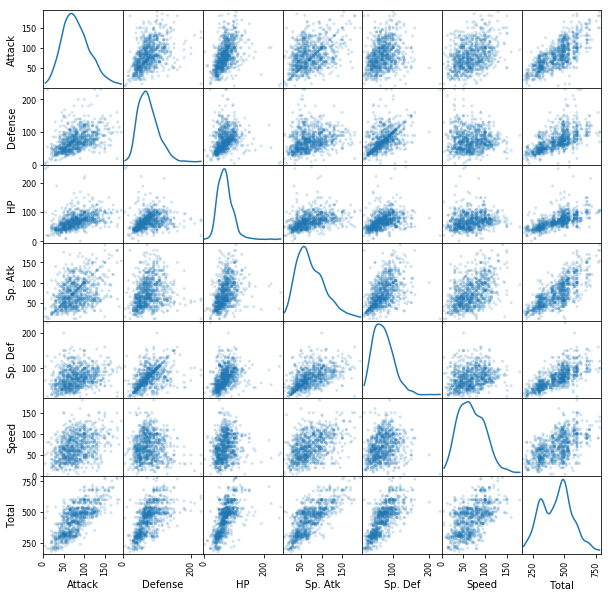

In [47]:
scatter_matrix(df[stats], alpha=0.2, figsize=(10, 10), diagonal='kde')